In [23]:
import numpy as np 
import matplotlib.pyplot as plt

In [58]:
type_training = ["SPEED", "ENDURANCE", "RECUPERATION"]   # Niveau 1
interval = ["short vma", "hills", "threshold", "fatleck", "cold water", "footing"]        # Niveau 2


# Initialization of the scores 
scores_type = np.zeros(len(type_training))
scores_interval = np.zeros((len(type_training), len(interval)))


def simulate_reward(distance, pace):
    reward_matrix = {
        "SPEED": {"short vma": 1.4, "hills": 0.3},   
        "ENDURANCE": {"threshold": 2.9, "fatleck": 1.6},
        "RECUPERATION": {"cold water": 0.1, "footing": 1.4}
    }
    return reward_matrix[distance][pace] + np.random.normal(0, 0.5)

optimal_rewards = {
    "SPEED": 1.4,
    "ENDURANCE": 2.9,
    "RECUPERATION": 1.4,
}

print(optimal_rewards)

def softmax(scores, mu):
    exp_scores = np.exp(scores / mu)
    return exp_scores / exp_scores.sum()

def return_intervals(idx_type):
    if idx_type == 0:
        return ["short vma", "hills"], [0, 1]
    elif idx_type == 1:
        return ["threshold", "fatleck"], [2, 3]
    else:
        return ["cold water", "footing"], [4, 5]

{'SPEED': 1.4, 'ENDURANCE': 2.9, 'RECUPERATION': 1.4}


In [59]:
n_iterations = 10 ** 4
L = 2
n_l = 2
Rl_bar = 1    # We assume R_S = 1
n_eff = (L * np.sqrt(n_l) * Rl_bar) ** 2
mu = np.sqrt(n_eff / 2)     # sqrt(n_eff / 2)
regret = []
cumulative_regret = 0


compt = 0
for t in range(1, n_iterations + 1):
    eta = np.sqrt(np.log(n_iterations) / (2 * t))    # Theorem 
    # Backward phase 
    prob_type = softmax(scores_type, mu)

    # select training
    idx_type = np.random.choice(len(type_training), p = prob_type)
    selected_training = type_training[idx_type]
    
    # Mise à jour des scores des allures pour la distance choisie
    prob_interval = softmax(scores_interval[idx_type], mu)
    
    # select interval
    sub_intervals, idx = return_intervals(idx_type)
    if idx == [2, 3]:
        compt += 1
    sub_prob = prob_interval[idx]
    sub_prob = sub_prob / sub_prob.sum()
    idx_interval = np.random.choice(len(sub_intervals), p = sub_prob)
    selected_interval = sub_intervals[idx_interval]
    
    # obtain reward
    reward = simulate_reward(selected_training, selected_interval)
    
    # Forward
    scores_interval[idx_type, idx_interval] += eta * (reward - scores_interval[idx_type, idx_interval])
    scores_type[idx_type] += eta * (reward - scores_type[idx_type])

    # Regret 
    optimal_reward = optimal_rewards[selected_training]
    cumulative_regret += (optimal_reward - reward)
    regret.append(cumulative_regret)

# Résultats finaux
print("Final scores of trainings :")
for i, type in enumerate(type_training):
    print(f"{type}: {scores_type[i]:.2f}")

print("\n Finals scores of intervals :")
for i, type in enumerate(type_training):
    sub_inter, _ = return_intervals(i)
    for j, inter in enumerate(sub_inter):
        print(f"{type} - {inter}: {scores_interval[i, j]:.2f}")

Final scores of trainings :
SPEED: 1.08
ENDURANCE: 2.35
RECUPERATION: 0.77

 Finals scores of intervals :
SPEED - short vma: 1.43
SPEED - hills: 0.34
ENDURANCE - threshold: 2.94
ENDURANCE - fatleck: 1.54
RECUPERATION - cold water: 0.17
RECUPERATION - footing: 1.45


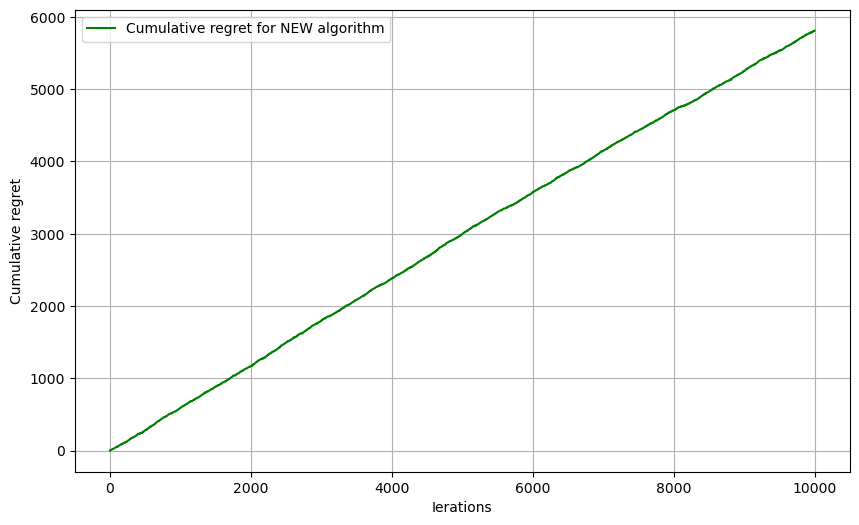

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), regret, label = "Cumulative regret for NEW algorithm", color = "green")
plt.xlabel("Ierations")
plt.ylabel("Cumulative regret")
plt.legend()
plt.grid()
plt.show()

Problèmes : 
- L'algorithme discrimine mal lorsqu'une solution est vraiment optimale. 
- Nécessité de connaître la structure. 